# Adam Smooth State Transition

Let's work again with

$$ f\left(x_1,x_2,x_3,x_4\right) = \exp\left(\sin\left(x_1^2 + x_2^2\right) + \sin\left(x_3^2 + x_4^2\right)\right) $$

## Dataset Creation

In [1]:
import torch
import numpy as np

from dataset import create_dataset

In [2]:
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)

dataset = create_dataset(f, n_var=4, train_num=3000)

In [3]:
import jax
import jax.numpy as jnp

X_train = jnp.array(dataset['train_input'].numpy())
X_test = jnp.array(dataset['test_input'].numpy())
y_train = jnp.array(dataset['train_label'].numpy())
y_test = jnp.array(dataset['test_label'].numpy())

## Initialization

In [4]:
import optax
from flax import linen as nn

import sys
import os

# Add /src to path
path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

from KAN import KAN

In [37]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [4, 5, 5, 1]

model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.02)
variables = model.init(key, jnp.ones([1, 4]))

## Optimizer

In [38]:
# Initialize optimizer from optax
boundaries = [0, 200, 400, 600] # Epochs at which to change the grid & learning rate
init_lr = 0.02
scales = [1.0, 0.5, 0.2, 0.5] # Learning rate scales
grid_vals = [3, 5, 10, 25] # Grid sizes to use

# Corresponding dicts
lr_scales = dict(zip(boundaries, scales))
grid_upds = dict(zip(boundaries, grid_vals))

# Create a piecewise constant schedule
schedule = optax.piecewise_constant_schedule(
    init_value=init_lr,
    boundaries_and_scales=lr_scales
)

optimizer = optax.adam(learning_rate=schedule, nesterov=True)

opt_state = optimizer.init(variables['params'])

In [39]:
def interpolate_moments(mu_old, nu_old, new_shape):
    """
    Interpolate moments from old state to new state.
    
    Args:
    - mu_old: First moment vector (mean) of the old state.
    - nu_old: Second moment vector (variance) of the old state.
    - new_shape: Tuple of the new shape.
    
    Returns:
    - Interpolated mu and nu for the new shape.
    """
    old_shape = mu_old.shape
    
    # Calculate scale factor for the second dimension
    scale_factor_j = old_shape[1] / new_shape[1]
    
    # Create new indices for the second dimension
    j_indices = jnp.floor(jnp.arange(new_shape[1]) * scale_factor_j).astype(int)
    
    # Map old moments to new moments using advanced indexing
    mu_new = mu_old[:, j_indices]
    nu_new = nu_old[:, j_indices]
    
    return mu_new, nu_new

In [27]:
from jax import vmap

def advanced_interpolate_moments(mu_old, nu_old, new_shape):
    old_shape = mu_old.shape
    size = old_shape[0]
    old_j = old_shape[1]
    new_j = new_shape[1]
    
    # Create new indices for the second dimension
    old_indices = jnp.linspace(0, old_j - 1, old_j)
    new_indices = jnp.linspace(0, old_j - 1, new_j)

    # Vectorize the interpolation function for use with vmap
    interpolate_fn = lambda old_row: jnp.interp(new_indices, old_indices, old_row)

    # Apply the interpolation function to each row using vmap
    mu_new = vmap(interpolate_fn)(mu_old)
    nu_new = vmap(interpolate_fn)(nu_old)
    
    return mu_new, nu_new

In [28]:
@jax.jit
def smooth_state_transition(old_state, variables):

    # Copy old state
    ###adam_count = jnp.array(0, dtype=jnp.int32)
    ###adam_count = jnp.round(old_state[0].count * 0.85).astype(jnp.int32)
    adam_count = old_state[0].count
    adam_mu, adam_nu = old_state[0].mu, old_state[0].nu

    # Get all layer-related keys, so that we do not touch the other parameters
    layer_keys = {k for k in adam_mu.keys() if k.startswith('layers_')}

    """
    for key in layer_keys:
        # Find the c_basis shape for this layer
        c_shape = variables['params'][key]['c_basis'].shape
        # Find the c_basis for this layer and initialize its mu to zero
        adam_mu[key]['c_basis'] = jnp.zeros(c_shape, dtype=jnp.float32)
        # Find the c_basis for this layer and initialize its nu to zero
        adam_nu[key]['c_basis'] = jnp.zeros(c_shape, dtype=jnp.float32)
    """
    for key in layer_keys:
        # Find the c_basis shape for this layer
        c_shape = variables['params'][key]['c_basis'].shape
        # Get new mu and nu
        mu_new, nu_new = advanced_interpolate_moments(adam_mu[key]['c_basis'], adam_nu[key]['c_basis'], c_shape)
        ##mu_new, nu_new = interpolate_moments(adam_mu[key]['c_basis'], adam_nu[key]['c_basis'], c_shape)
        # Set them
        adam_mu[key]['c_basis'], adam_nu[key]['c_basis'] = mu_new, nu_new
    

    # Make new adam state
    adam_state = optax.ScaleByAdamState(adam_count, adam_mu, adam_nu)
    # Make new scheduler state if using scheduling, otherwise an empty state
    extra_state = optax.ScaleByScheduleState(adam_count)
    ###extra_state = optax.EmptyState()
    # Make new total state
    new_state = (adam_state, extra_state)

    return new_state

## Loss Function

In [10]:
def full_loss_fn(params, x, y, state):
    variables = {'params' : params, 'state' : state}
    # Forward pass to acquire predictions and spl_regs
    preds, spl_regs = model.apply(variables, x)

    # Define the prediction loss
    loss_pred = jnp.sqrt(jnp.mean((preds-y)**2))

    # Calculate the regularization loss
    loss_reg = 0.0
    for spl_reg in spl_regs:
        # L1 regularization loss
        phis = spl_reg.reshape(-1)
        L1 = jnp.sum(phis)
        # Entropy regularization loss
        frac = phis/L1
        Entropy = -jnp.sum(frac * jnp.log2(frac + 1e-4))
        # Return full regularization loss
        mu_1, mu_2 = 1.0, 1.0
        loss_reg += (mu_1 * L1) + (mu_2 * Entropy)

    # Return total loss
    ell = 0.0
    total_loss = loss_pred + (ell * loss_reg)
    
    return total_loss

In [11]:
def simple_loss_fn(params, x, y, state):
    variables = {'params' : params, 'state' : state}
    # Forward pass to acquire predictions and spl_regs
    preds, spl_regs = model.apply(variables, x)

    # Define the prediction loss
    loss_pred = jnp.sqrt(jnp.mean((preds-y)**2))
    
    return loss_pred

## Training

In [12]:
@jax.jit
def train_step(params, opt_state, x, y, state):
    
    loss, grads = jax.value_and_grad(simple_loss_fn)(params, x, y, state)
    
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    new_variables = {'params': params, 'state': state}
    
    return new_variables, opt_state, loss

In [40]:
# Training epochs
num_epochs = 800

train_losses = []
eval_losses = []
for epoch in range(num_epochs):
    # Check if we're in an update epoch
    if epoch in grid_upds.keys():
        print(f"Epoch {epoch+1}: Performing grid update")
        # Get grid size
        G_new = grid_upds[epoch]
        # Perform the update
        updated_variables = model.apply(variables, X_train, G_new, method=model.update_grids)
        variables = updated_variables.copy()
        # Re-initialize optimizer smoothly when using optax - Adam
        opt_state = smooth_state_transition(opt_state, variables)
        
    # Calculate the loss
    params, state = variables['params'], variables['state']
    variables, opt_state, loss = train_step(params, opt_state, X_train, y_train, state)
    
    train_losses.append(loss)

    # Let's also log evaluation losses, so that we can re-create the training graphs shown in the arXiv pre-print
    eval_preds, _ = model.apply(variables, X_test)
    eval_loss = jnp.sqrt(jnp.mean((eval_preds - y_test) ** 2))

    eval_losses.append(eval_loss)

Epoch 1: Performing grid update
Epoch 201: Performing grid update
Epoch 401: Performing grid update
Epoch 601: Performing grid update


## Results

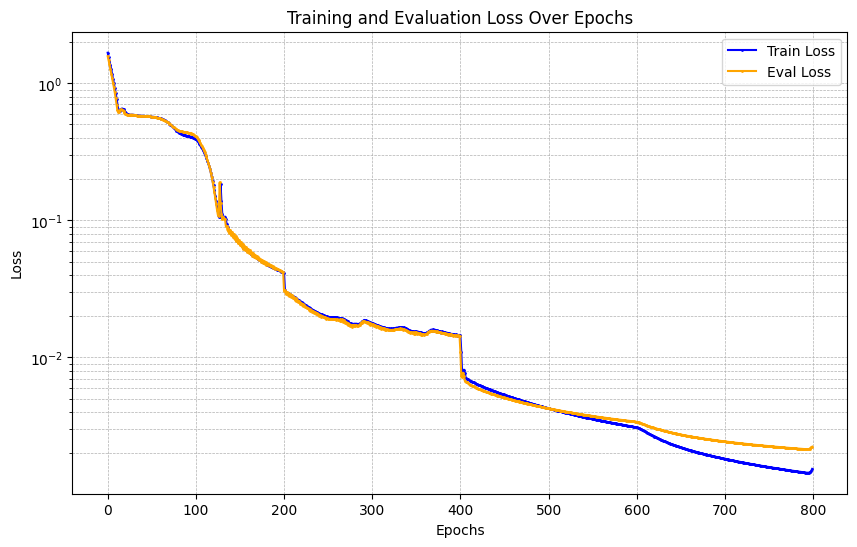

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss', marker='o', color='blue', markersize=1)
plt.plot(eval_losses, label='Eval Loss', marker='o', color='orange', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.savefig('loss_curves.png')
plt.show()

We can see the plateaus mentioned in the original paper, albeit with some sharp spikes whenever we re-initialize Adam. Let's now compare the actual evaluation results to the ground truth.

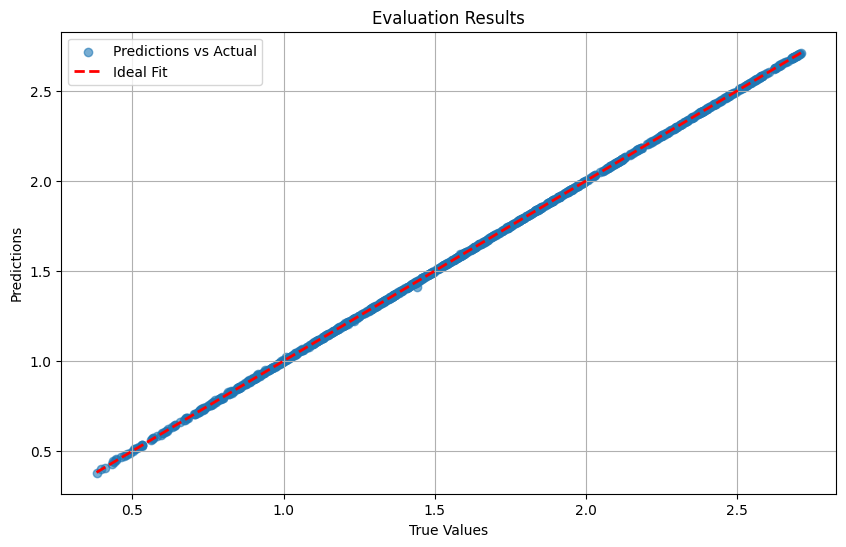

In [31]:
import matplotlib.pyplot as plt

# Plot the evaluation results
plt.figure(figsize=(10, 6))

plt.scatter(y_test, eval_preds, label='Predictions vs Actual', alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Evaluation Results')

plt.legend()
plt.grid(True)

plt.savefig('eval_results.png')
plt.show()

The fit is more than satisfactory.